###### Build an email prioritization model

Priority can be defined as how quick an email needed to be dealt with, the content of the email, how quickly it was responded to etc. There's no ground truth on priority, with the hints previously mentioned, you'll need to create your own ground truth (target labels) on priority and explain the rationale behind this. 

The features you can use is left open, how you model the problem is also left open. We'd say, start with something simple first.

Evaluation:  We want to see for a given email that your model has never seen, how good the model is in determining the email's priority. It's recommended that you keep a portion of the dataset here to evaluate your model. Feel free to use standard metrics or create a new ones.

Email if you have any questions

In [1]:
## https://docs.python.org/3/library/datetime.html
from datetime import datetime
def to_timestamp(d):
    ''' Given an ISO format date string, convert to unix timestamp '''
    return datetime.timestamp(datetime.fromisoformat(d))

def to_datetime(d):
    ''' Given an ISO format date string, convert to datetime object '''
    return datetime.fromisoformat(d)

In [2]:
import nltk
nltk.download('brown')
import re, difflib
from sklearn.neighbors import KDTree
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences

import warnings
warnings.simplefilter("ignore")

from nltk.tokenize import word_tokenize

def strip_spaces(s):
    return re.sub('[ ]+', ' ', s).strip()

def ContentExtraction(mail, ContentSplitters):
    '''
    Slicing email body content than signature and disclaimers
    '''
    lmtr = [lmtr for lmtr in ContentSplitters if lmtr in mail.lower()]
    if len(lmtr)>0:
        limiter = re.search(lmtr[0], mail.lower()).start()
        return mail[:limiter]
    return mail

def Remove_URLs(x):
    '''
    Removing URLs from the mail body
    '''
    x = word_tokenize(x)
    x = [i for i in x if not len(re.findall(r'[\w\.-]+@[\w\.-]+',i))]
    x = ' '.join(x)
    return x


def preprocess_mail(text, punctuation=False):
    '''
    Preprocessing the email content 
    removing punctuations except few required
    strip spaces
    
    
    '''
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub('[^A-Za-z0-9 ,.]+', '', text.replace('\n',' ')).lower()
    text = strip_spaces(text)
    text = text.replace(',',' , ').replace('.',' . ')
    text = ContentExtraction(text, ContentSplitters)
    text = Remove_URLs(text)
    if punctuation:
        text = re.sub('[^A-Za-z0-9 ]+', '', text.replace('\n',' ')).lower()
    
    return text


ContentSplitters  = ['best regards', 'rgds ','b rgds', '\ngreetings', '\nthanks.', '\nthanks,', '\nthank you','\nthank you,', '\nthank you\n', 'sincerely', 'regard ',
                      'regards', 'kind regards', 'the information contained in this','forwarded', '\ntel:', '\nMobile:', '\nall the best,','\ncordially',
                      '[image: image.png]','thx','Tel:','Fax:','greeting', '\nproject manager ', 'from:', 'envoyé :', 
                      'the information contained in this email are confid', '------- forwarded message -----', 
                      'proprietary and confidential.','\nthanks a lot', 'tel. ','Please consider your environmental responsibility',
                      'The administrator of your personal data','the information transmitted in this e-mai',  'Deze email en de bijgevoegde', 'this e-mail is intended only for the person or entity']



[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\nagak\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [3]:

# Building a trie to add and remove words faster way
class Trie:
    head = {}
    
    def add(self,word):

        cur = self.head
        for ch in word:
            if ch not in cur:
                cur[ch] = {}
            cur = cur[ch]
        cur['*'] = True

    def search(self,word):
        cur = self.head
        for ch in word:
            if ch not in cur:
                return False
            cur = cur[ch]

        if '*' in cur:
            return True
        else:
            return False
    def printf(self):
        print (self.head)

# %%timeit
# trie_dict.search("paper")
# 503 ns ± 1.57 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
# %%timeit
# 'paper' in words1
# 1.26 ms ± 76.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Tried with recursive manner of linking mails
# df = df.sort_values('time')
# df = df[~df[['uniqueID','uniqueID_rsp']].duplicated()]
# seq = []
# for ind, row in df.iterrows():
#     li = [[row['uniqueID'], row['time'].timestamp()], [row['uniqueID_rsp'], row['time_rsp'].timestamp()]]
#     seq.append(sorted(li, key=lambda x: x[1]))
    

        

def get_nearest_word(search_w, stopwords, words1, excess=1000):
    '''
    Function to search nearest possible word, like 
    c[icking -> clicking
    corrections to mail words mentioned in mail body
    
    '''

#     words1 = [list(map(ord, i)) for i in set(words)]
#     max_length = max(map(len, words1))
#     words1 = pad_sequences(words1, max_length)
#     tree = KDTree(words1, leaf_size=8)
    if search_w in stopwords:
        return [search_w, 1]
    dist = 0
    left = 0
    right = len(words1)
    while left<=right:
        mid = (left+right)//2
        d = difflib.SequenceMatcher(None, search_w ,words1[mid]).ratio()
        if d==1:
            break
        elif d<dist:
            left =  mid + 1
        else:
            dist = d
            right = mid - 1
    
    dist = ['',0, 0]
    for ind, w in enumerate(words1[mid-excess:mid+excess]):
        d = difflib.SequenceMatcher(None, search_w, w).ratio()
        if d==1:
            dist = [w, d]
            return dist
        if d>dist[1]:
            dist = [w, d]
    return dist

def concatenate_words(s, i, stopwords, words1, excess, word_size=9):
    '''
    search and concatenating the space delimited words 
    fell ow  -> fellow
    coordin ate  -> coordinate
    
    
    '''
    te = []
    for j in [0,-1]:
        search_w = []
        if j==-1 and i>0:
            search_w.append(s[i-1])
        threshold = 0
        for ind, w in enumerate(s[i:]):
            
            if threshold>word_size: break
            threshold+=len(w)
            search_w.append(w)
#             print(search_w)
#             print(''.join(search_w) in words1)
#             r = get_nearest_word(''.join(search_w), stopwords, words1, excess=excess)
            
#             if r[1]==1:
#                 return ind+1, r[0], j
#             te.append(r)
#             if ''.join(search_w) in words1: #r[1]==1:
            if trie_dict.search(''.join(search_w)):
                return ind+1, ''.join(search_w), j
            
    return None, '', None



def sequence_processing(s, stopwords, words1, excess, word_size=6):
    '''
    sequence processing from to add space delimited words in sequnce
    
    sequence :
    'wion is un iquely positioned as the globa l voice of ind ia , present ing its own perspective on 
    international issues of critical significance .'
    
    Out:
    'wion is uniquely positioned as the global of india , presenting its own perspective on international
    issues of critical significance .'
    
    '''
    res = []
    w = 0
    while w<len(s):
        # d = get_nearest_word(s[w], stopwords, words1, excess=excess)
        if trie_dict.search(s[w]):
            res.append(s[w])
        else:
            d1 = concatenate_words(s, w, stopwords, words1, excess, word_size)
            if d1[2]==-1:
                res.pop()
                res.append(d1[1])
            elif d1[2]==0:
                res.append(d1[1])
                w += d1[0]
            else:
                res.append(s[w])
        w +=1
    return ' '.join(res)


# Building a trie of english available words
import string
stopwords = nltk.corpus.stopwords.words('english')

# Selecting vocal library of english words 
words = nltk.corpus.brown.words()
words1 = []
for w in words:
    w = w.lower()
    w = re.sub('[0-9]','', w)
    words1.append(w)
words1 = list(set(words1))
words1.sort()

# adding all possible words to trie to make ease of search
trie_dict = Trie()
for word in words1:
    if '*' not in word and word not in list(string.ascii_lowercase+string.ascii_uppercase+string.digits):
        trie_dict.add(word)


# %%time
# s = 'wion is un iquely positioned as the globa l voice of ind ia , present ing its own perspective on international issues of critical significance .'
# sequence_processing(s.split(' '), stopwords, words1, tune)
# Out: 'wion is uniquely positioned as the global of india , presenting its own perspective on international issues of critical significance .'
# before code optimization
# Wall time: 8.43 s

# after code optimization
# 38.2 µs ± 893 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Exception need to be handled
# s = 'if you are interested and available to talk to us through a phone call at 1030 am friday or saturd ay this w e e k , or sometime betwee n 930 and 1030 am next mond ay , please let us know .'
# sequence_processing('this w e e k , or'.split(' '), stopwords, words1, lr, word_size=15)
        


In [4]:
import pickle
email_chain_pairs = pickle.load(open('email_chains.pkl','rb'))


ec = email_chain_pairs
ml = pd.DataFrame([i[0] for i in ec])
rs = pd.DataFrame([i[1] for i in ec])

ml['time']= pd.to_datetime(ml['time'], utc=True)
rs['time'] = pd.to_datetime(rs['time'], utc=True)
df = ml.join(rs.add_suffix('_rsp'))
df['target'] = df['time_rsp'] - df['time']

df['uniqueID'] = df[['sender', 'time', 'subject']].astype(str).apply(' - '.join,1)
df['uniqueID_rsp'] = df[['sender_rsp', 'time_rsp', 'subject_rsp']].astype(str).apply(' - '.join,1)

In [5]:
df['mail'] = np.where((df['time_rsp']-df['time'])<pd.to_timedelta('1s'), df['body_rsp'], df['body'])
df['text'] =df['mail'].apply(preprocess_mail)
df['target'] = df['time_rsp'].subtract(df['time']).dt.total_seconds().abs()
df['text1'] = df.apply(lambda x: ''.join(sequence_processing(sent.split(' '), stopwords, words1, excess=30000, word_size=15) for sent in nltk.tokenize.sent_tokenize(x['text'])),1)

In [6]:
s = 'i was a post doctoral fe llow in the laboratory of viral and molecular pathogenesis at nih . i dont know if the same lab is still there '
sequence_processing(s.split(' '), stopwords, words1, excess=30000, word_size=15)

'i was a post doctoral fellow in the laboratory of viral and molecular pathogenesis at nih . i dont know if the same lab is still there '

In [ ]:
'''
Function intended map loop chain of mails recieved and forwarded from respective id in recursive manner

Analysis purpose - not utilized at here
'''
# def recur(sq, key, res):
#     print(key)
#     for s in range(len(sq)):
#         print(sq[s][2])
#         if sq[s][2]==0 and sq[s][0][0]==key:
#             print('got in')
#             sq[s][2] = 1
#             sq, res = recur(sq, sq[s][1][0], res+[sq[s][0][0]])
#     return sq, res
        
#       results = []
# for i in range(len(seq))[:3]:
#     if key == seq[i][1][0]:
#         print('found')
#     if seq[i][2]==0:
#         seq[i][2]=1
#         seq, res = recur(seq, seq[i][1][0], [seq[i][1][0]])
#         results.append(res)  

In [ ]:
# # x = ml.sample(1).iloc[0]
# x = df.sample(1).iloc[0]

# sents = []
# lr=4000
# for s in nltk.tokenize.sent_tokenize(x['text']):
#     sent = sequence_processing(s.split(' '), stopwords, words1, lr, word_size=15)
#     sents.append(sent)

In [264]:
x = df.sample(1).iloc[0]
print(x['text'])

dr . fauci , how are you sir long ago , in the early 90s , i was a post doctoral fe llow in the laboratory of viral and molecular pathogenesis at nih . i dont know if the same lab is still there . now i work on brain injury and alzheimers but my interest in viruses and mechanisms of viral pathogenesis has not waned and the recent covid19 outbreak prompted me to do a little investigation on my own . my studies of blood microrna changes after tbi and ad suggest that principal component analysis of distinct changes in circulating mirnas can identify the patient population . microrna alterations can be measured by realtime pcrwhich i presume is the basis of the test that is developed for this disease but i am analyzing blood mi rnaseq expression profiles and now it is possible to quickly sequence blood samples in a few hours and get accurate results . blood gene expression in my studies was more var iable lots of rnasesin blood so i found that micrornas are much more stable in blood and se

In [265]:
print(x['text1'])

dr.fauci , how are you sir long ago , in the early 90s , i was a post doctoral fellow in the laboratory of viral and molecular pathogenesis at nih .i dont know if the same lab is still there .now i work on brain injury and alzheimers but my interest in viruses and mechanisms of viral pathogenesis has not waned and the recent covid19 outbreak prompted me to do a little investigation on my own .my studies of blood microrna changes after tbi and ad suggest that principal component analysis of distinct changes in circulating mirnas can identify the patient population .microrna alterations can be measured by realtime pcrwhich i presume is the basis of the test that is developed for this disease but i am analyzing blood mi rnaseq expression profiles and now it is possible to quickly sequence blood samples in a few hours and get accurate results .blood gene expression in my studies was more variable of rnasesin blood so i found that micrornas are much more stable in blood and serum samples .i

In [7]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(style='seaborn')
%matplotlib inline

from sklearn.model_selection import train_test_split


import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

def preprocesse_text(df, test_size=0.2, stopwords=[]):
    '''
    Building a N-gram based model with words sequence from 1 to 6 words 
    restring max features to 45000
    added character based features 
    
    concatenated both feature vectors in modelling
    
    '''
    train_text,test_text,y_train,y_test = train_test_split(df['text1'], df['target'], test_size=test_size)

    all_text = pd.concat([train_text, test_text])

    word_vectorizer = TfidfVectorizer(
        sublinear_tf=True,
        strip_accents='unicode',
        analyzer='word',
        token_pattern=r'\w{1,}',
        stop_words=stopwords,
        ngram_range=(1, 6),
        max_features=45000)
    word_vectorizer.fit(all_text)
    train_word_features = word_vectorizer.transform(train_text)
    test_word_features = word_vectorizer.transform(test_text)

    char_vectorizer = TfidfVectorizer(
        sublinear_tf=True,
        strip_accents='unicode',
        analyzer='char',
        stop_words=stopwords,
        ngram_range=(5, 6),
        max_features=10000)
    char_vectorizer.fit(all_text)
    train_char_features = char_vectorizer.transform(train_text)
    test_char_features = char_vectorizer.transform(test_text)

    train_features = hstack([train_char_features, train_word_features])
    test_features = hstack([test_char_features, test_word_features])
    return train_features, test_features, train_word_features, train_char_features, y_train, y_test, test_text, word_vectorizer, char_vectorizer

<AxesSubplot:>

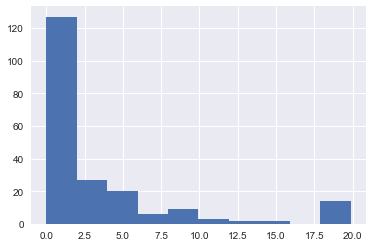

In [10]:
'''
Plotting the model predictions with percent of change from the actual

'''

from sklearn.linear_model import LinearRegression

train_features, test_features, train_word_features, train_char_features, y_train, y_test, test_text, word_vectorizer, char_vectorizer = preprocesse_text(df, test_size=0.2, stopwords=nltk.corpus.stopwords.words('english'))
reg = LinearRegression()
reg.fit(train_features, y_train)

te = pd.DataFrame()
te['text'] = test_text
te['preds'] = reg.predict(test_features)
te['target'] = y_test
te['diff'] = te['target']-te['preds']
te['percent'] = te['diff'].abs().div(te['target'])
te = te.sort_values('percent')
te.iloc[:int(len(te)*0.9)]['percent'].hist()

In [11]:
'''
Feature weights analyzation to either keep or discard from modelling
'''
features = pd.DataFrame()
features['weights'] = pd.Series(reg.coef_)
features['features'] = word_vectorizer.get_feature_names()+char_vectorizer.get_feature_names()
features['wgt'] = features['weights'].abs()
features['wgt'].describe()

count     55000.000000
mean      17070.625363
std       34140.034756
min           0.000000
25%        2134.910436
50%        4930.414706
75%       17130.933567
max      973998.906526
Name: wgt, dtype: float64

In [12]:
# Chekcking model weights which are  most prominant in modelling
thr = features['wgt'].quantile(0.5)
features[features['wgt'].gt(thr)].sort_values('wgt', ascending=False)['features'].tolist()[:15]

['would possible',
 'moving forward gratifying speed commitment',
 'covid19 effortsin china zy',
 'hit chris',
 ' sick',
 'health care system novel coronavirus outbreak',
 'epidemic administered exposed people',
 'spokewith',
 'confir',
 'nonspecific immune',
 'system staff working',
 'tedros tweet stephanie nebehay stephanie nebehay',
 'undetected many unknowns sarscov2',
 'work help',
 'test result permitted board flights']

In [13]:
# Chekcking model weights which are less contributing to model 
features[features['wgt'].lt(thr)].sort_values('wgt', ascending=False)['features'].tolist()[:15]

['international english news',
 'cobtoday hi patty reporter writing ncaas',
 'cell symposium emerging reemerging viruses 2017',
 'workforce expansion e g widescale',
 'workforce expansion e g',
 'allin',
 '1 welcome introductions 2 background proposal',
 'could syndicate parts externally social channels',
 'advance team international experts led world',
 'keen hear man',
 'reviewed edited attached response appreciateyour expedited',
 'floor new york',
 'clinics dont typically undergo fit',
 'commend extraordinary efforts government',
 '13th dec']

In [14]:
features['gram_type'] = ['ngrams']*train_char_features.shape[1] + ['char grams']*train_word_features.shape[1]

In [15]:
'''
Checking the model weights in consideration to character and n gram based feature words
'''
features.groupby('gram_type')['wgt'].describe()

,count,mean,std,min,25%,50%,75%,max
gram_type,,,,,,,,
char grams,45000.0,12442.107330,30333.256634,0.000000,1507.970038,3784.999534,9544.394225,973998.906526
ngrams,10000.0,37898.956512,41712.438860,1.972068,10559.129773,25344.885495,48930.253585,355834.796445


In [16]:
'''
Checking the most prominant n-gram size for modelling
'''
features[:train_char_features.shape[1]].groupby(features['features'].str.split(' ').apply(len))['wgt'].describe()

,count,mean,std,min,25%,50%,75%,max
features,,,,,,,,
1,1504.0,37470.965327,42563.968379,70.839886,9640.877179,24549.970594,49157.641113,328389.018847
2,2016.0,39812.695132,43529.448213,102.503251,11232.179002,26086.826227,50986.680053,353352.973463
3,1714.0,36714.078229,39835.147428,41.745847,10253.830283,24792.048434,48096.406276,308471.618034
4,1634.0,37075.183352,40680.707996,1.972068,10683.856881,25336.759384,47659.325324,343383.063939
5,1581.0,37373.377809,40046.638510,186.542120,10594.329381,25047.103121,48113.730421,355834.796445
6,1551.0,38539.490574,43177.281371,4.938738,10103.697955,25531.056259,49970.715875,342254.488260


In [17]:
'''
Considering the analysis of model weights and removing unsupportive key words which are not contributing to model
'''
extra_stopwords = features[features['wgt'].lt(thr)].sort_values('wgt', ascending=False)['features'].tolist()

In [18]:
'''
Re initiating the model by removing the inappropriate key words as stopwords and ngram selection

'''

train_features, test_features, train_word_features, train_char_features, y_train, y_test, test_text, word_vectorizer, char_vectorizer = preprocesse_text(df, test_size=0.2, stopwords=nltk.corpus.stopwords.words('english')+extra_stopwords)

reg = LinearRegression()
cv_score = np.mean(cross_val_score(reg, train_features, y_train.values, cv=3, scoring='r2'))
reg.fit(train_features, y_train)

te = pd.DataFrame()
te['text'] = test_text
te['preds'] = reg.predict(test_features)
te['target'] = y_test
te['diff'] = te['target']-te['preds']
te['percent'] = te['diff'].abs().div(te['target'])
te = te.sort_values('percent')

features = pd.DataFrame()
features['weights'] = pd.Series(reg.coef_)
features['features'] = word_vectorizer.get_feature_names()+char_vectorizer.get_feature_names()
features['wgt'] = features['weights'].abs()

<AxesSubplot:>

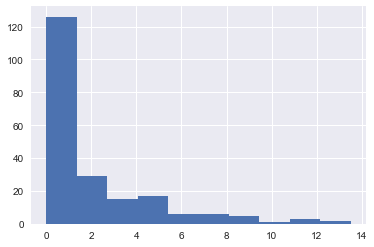

In [19]:
te.iloc[:int(len(te)*0.9)]['percent'].hist()

In [20]:
## Saving the generated model
with open('regressor.pkl','wb') as f:
    pickle.dump(reg, f)
    pickle.dump(word_vectorizer, f)
    pickle.dump(char_vectorizer, f)